[View in Colaboratory](https://colab.research.google.com/github/SakshiPriya/inverted-visualization/blob/master/m&v_inverted_visualization_.ipynb)

In [0]:
 !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
 !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
 !apt-get update -qq 2>&1 > /dev/null
 !apt-get -y install -qq google-drive-ocamlfuse fuse
 from google.colab import auth
 auth.authenticate_user()
 from oauth2client.client import GoogleCredentials
 creds = GoogleCredentials.get_application_default()
 import getpass
 !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
 vcode = getpass.getpass()
 !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [0]:
!pip install torch
!pip install torchvision
!pip install pillow==4.0.0

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5a3cc000 @  0x7f4178aea1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 5.0MB/s 
    100% |████████████████████████████████| 2.0MB 13.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.6MB 6.6MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms,models
from PIL import Image
from torch import optim

In [0]:


mean=torch.Tensor([0.485, 0.456, 0.406])
std=torch.Tensor([0.229, 0.224, 0.225])
def transformimage(image):
  transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean,std)])
  transformedimage=transform(image)
  transformedimage=transformedimage.unsqueeze(0)
  return transformedimage
  
untransform=transforms.ToPILImage()
grayscale=transforms.Grayscale()
def showimage(transformedimage,show,gradient):
    untrans_image=transformedimage.squeeze(0)
    if show==True:
       for i in range(untrans_image.shape[0]):
          untrans_image[i]=untrans_image[i]*(std[i].double())+(mean[i].double())
       
    elif gradient==True:
         untrans_image=(untrans_image-untrans_image.min())/untrans_image.max()
    untrans_image=untrans_image.float()
    untrans_image=untransform(untrans_image)
    plt.figure()
    plt.imshow(untrans_image)
    plt.show()
    return untrans_image
  


In [0]:
listofimages=[['drive/app/goldfish.jpg',1],
              ['drive/app/hamster.jpg',333],
              ['drive/app/jellyfish.jpg',107]]


index=0
layervisual=9
imgpath=listofimages[index][0]
classid=listofimages[index][1]
model=models.vgg19(pretrained=True)
image=Image.open(imgpath)
imagetensor=transformimage(image)
initial_img=torch.tensor(np.random.normal(0,1,imagetensor.size()),requires_grad=True,dtype=torch.float)
model=model.eval().float()

model.to('cpu')


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /content/.torch/models/vgg19-dcbb9e9d.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
def outputoflayer(layerno,inputs):
  i=0
  for layer in model.features:
    inputs=layer(inputs)
    if i==layerno:
      break
    i+=1
  return inputs
    



def vectorization(image,power):
  return (image.view(-1)**power).sum()

def lossfunc(output,target,layer):
  result=0
  lambda_alpha=2.16e-8
  #if layer in range(11):
    #lambda_beta=0.05
  #elif layer in range(21):
     #lambda_beta=0.5
  #else:
  lambda_beta=1e-8
  alpha=6
  beta=2
  
  distance=target-output
  euclidean_loss=vectorization(distance,2)/vectorization(output,2) 
  regularizer1=lambda_alpha*vectorization(output,alpha) 
  
  
  for i in range(output.size()[2]-1):
    for j in range(output.size()[3]-1):
      result+=( ((output[0,:,i,j+1]-output[0,:,i,j])**2 + (output[0,:,i+1,j]-output[0,:,i,j])**2 )**(beta/2)).sum()
      
  regularizer2=lambda_beta*result
  return euclidean_loss+regularizer1+regularizer2



In [0]:
epochno=2000
targetimage=outputoflayer(layervisual,imagetensor).detach()
optimizer=optim.SGD([initial_img],lr=0.001,momentum=0.9)
for i in range(epochno):
  optimizer.zero_grad()
  input_image=outputoflayer(layervisual,initial_img)
  loss=lossfunc(input_image,targetimage,layervisual)
  print('loss{}:{}'.format(i,loss))
  loss.backward()
  optimizer.step()
  
  


loss0:202282.90625
loss1:73904.890625
loss2:40051.3671875
loss3:31736.220703125
loss4:30877.375
loss5:28472.771484375
loss6:25556.58203125
loss7:22777.57421875
loss8:20210.115234375
loss9:18133.037109375
loss10:16118.3310546875
loss11:14163.32421875
loss12:12488.71875
loss13:11160.427734375
loss14:9979.5771484375
loss15:8962.8515625
loss16:8113.58544921875
loss17:7385.77978515625
loss18:6729.2900390625
loss19:6130.443359375
loss20:5594.47265625
loss21:5124.74951171875
loss22:4715.64501953125
loss23:4361.23583984375
loss24:4051.7529296875
loss25:3779.163330078125
loss26:3537.065185546875
loss27:3319.7900390625
loss28:3122.739990234375
loss29:2942.314208984375
loss30:2776.9580078125
loss31:2624.89599609375
loss32:2485.33642578125
loss33:2357.833984375
loss34:2240.880126953125
loss35:2134.302978515625
loss36:2036.893798828125
loss37:1947.897216796875
loss38:1866.4366455078125
loss39:1791.5799560546875
loss40:1722.6351318359375
loss41:1659.1199951171875
loss42:1600.414306640625
loss43:1545

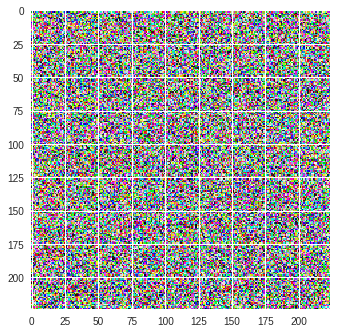

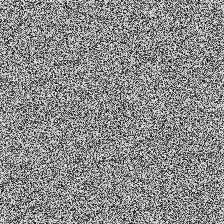

In [0]:
img=showimage(initial_img,False,True)
grayscale(img)